In [51]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

#     # UDACITY Compute the number of windows in x/y
#     nx_windows = np.int(xspan/nx_pix_per_step) - 1
#     ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # KENNY Compute the number of windows in x/y
    # I think more correctly that actually keeps it in bounds
    nx_windows = np.int(1 + (xspan - xy_window[0])/nx_pix_per_step)
    ny_windows = np.int(1 + (yspan - xy_window[1])/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [3]:
cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')
sample_size = 10000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

In [4]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
10.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9662


In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [6]:
from collections import deque

class Pipeline2():
    def __init__(self,xy_windows=[]):
        self.recent_heatmaps = None
        self.heatmap = None
        self.heat_frames = 5
        self.heat_threshold = 4
        self.xy_windows = xy_windows
    def process_frame(self,image):
        if self.heatmap == None:
            # initialize heatmap and recent heatmaps
            self.heatmap = np.zeros_like(image[:,:,0])
            self.recent_heatmaps = deque([])
            for i in range(self.heat_frames):
                self.recent_heatmaps.append(self.heatmap)
        
        draw_image = np.copy(image)
        image = image.astype(np.float32)/255
        
        # collect windows that classify a car over different window sizes
        all_hot_windows = []
        for xy_window in self.xy_windows:
            # 400 is top of the cars which is pretty constant (at least for cars of a certain size...)
            # xy_window[1] is the window height. Search just over a band.
            y_start = 400
            y_start_stop = [y_start, y_start + xy_window[1]*1]
#             y_start_stop = [400, None]
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=(0.5, 0.5))

            hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            all_hot_windows += hot_windows
        
        #create heatmap of zeros
        new_heatmap = np.zeros_like(self.heatmap)
        #add heat based on current frame
        add_heat(new_heatmap, all_hot_windows)
        #update sliding collection of heatmaps by appending to right and popping left
        self.recent_heatmaps.append(new_heatmap)
        self.recent_heatmaps.popleft()
        self.heatmap = np.sum(self.recent_heatmaps,axis=0)
        self.heatmap = apply_threshold(self.heatmap, threshold=self.heat_threshold)
        
        
#         window_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=6)                    
#         return window_img
        
        labels = label(self.heatmap)
        draw_img = draw_labeled_bboxes(draw_image, labels)
        return draw_img

In [23]:
from collections import deque
from scipy.ndimage.measurements import label

class Pipeline():
    def __init__(self,xy_windows=[],
                 xy_overlap=(0.5, 0.5),
                 heat_frames=7,
                 heat_threshold=6):
        self.recent_heatmaps = None
        self.heatmap = None
        self.xy_windows = xy_windows
        self.xy_overlap = xy_overlap
        self.heat_frames = heat_frames
        self.heat_threshold = heat_threshold
    def process_frame(self,image):
        if self.heatmap == None:
            # initialize heatmap and recent heatmaps
            self.heatmap = np.zeros_like(image[:,:,0])
            self.recent_heatmaps = deque([])
            for i in range(self.heat_frames):
                self.recent_heatmaps.append(self.heatmap)
        
        draw_image = np.copy(image)
        image = image.astype(np.float32)/255
        
        # collect windows that classify a car over different window sizes
        all_hot_windows = []
        for xy_window in self.xy_windows:
            # 400 is top of the cars which is pretty constant (at least for cars of a certain size...)
            # xy_window[1] is the window height. Search just over a band.
            y_start = 400
            y_start_stop = [y_start, y_start + xy_window[1]]
#             y_start_stop = [400, None]
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=self.xy_overlap)

            hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            all_hot_windows += hot_windows
        
        #create heatmap of zeros
        new_heatmap = np.zeros_like(self.heatmap)
        #add heat based on current frame
        add_heat(new_heatmap, all_hot_windows)
        #update sliding collection of heatmaps by appending to right and popping left
        self.recent_heatmaps.append(new_heatmap)
        self.recent_heatmaps.popleft()
        self.heatmap = np.sum(self.recent_heatmaps,axis=0)
        self.heatmap = apply_threshold(self.heatmap, threshold=self.heat_threshold)
        
        self.all_hot_windows = all_hot_windows
        
        labels = label(self.heatmap)
        draw_img = draw_labeled_bboxes(draw_image, labels)
        return draw_img

In [73]:
from moviepy.editor import VideoFileClip

def process_movie(fname, output_fname):
    clip = VideoFileClip(fname)
    pipeline = Pipeline(xy_windows = [(100,100),(125,125),(150,150),(200,200)],xy_overlap=(0.75, 0.75)) #(75,75),(100,100),(125,125),
    clip_output = clip.fl_image(pipeline.process_frame)
    %time clip_output.write_videofile(output_fname, audio=False, codec='mpeg4')
    print('mean heatmap after = ',np.mean(pipeline.heatmap))
    plt.imshow(pipeline.heatmap)

[MoviePy] >>>> Building video test_video_2_output.mp4
[MoviePy] Writing video test_video_2_output.mp4


 99%|█████████▉| 124/125 [00:38<00:00,  3.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_2_output.mp4 



CPU times: user 33.7 s, sys: 2.8 s, total: 36.5 s
Wall time: 38.3 s
mean heatmap after =  2.84244791667


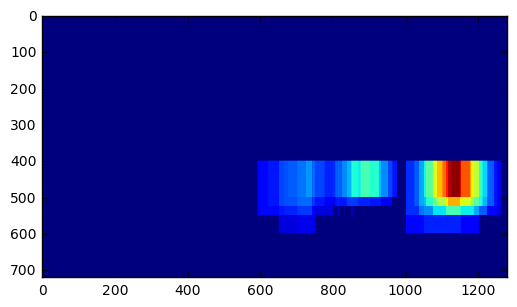

In [75]:
moviename = 'test_video_2'

fname = moviename + '.mp4'
output_fname = moviename + '_output.mp4'
process_movie(fname,output_fname)

[((0, 400), (100, 500)), ((100, 400), (200, 500)), ((200, 400), (300, 500)), ((300, 400), (400, 500)), ((400, 400), (500, 500)), ((500, 400), (600, 500)), ((600, 400), (700, 500)), ((700, 400), (800, 500)), ((800, 400), (900, 500)), ((900, 400), (1000, 500)), ((1000, 400), (1100, 500)), ((1100, 400), (1200, 500)), ((0, 450), (100, 550)), ((100, 450), (200, 550)), ((200, 450), (300, 550)), ((300, 450), (400, 550)), ((400, 450), (500, 550)), ((500, 450), (600, 550)), ((600, 450), (700, 550)), ((700, 450), (800, 550)), ((800, 450), (900, 550)), ((900, 450), (1000, 550)), ((1000, 450), (1100, 550)), ((1100, 450), (1200, 550))]


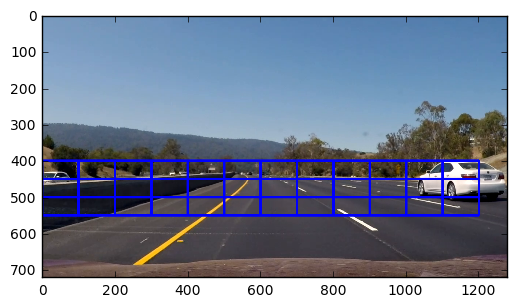

In [55]:
clip0 = VideoFileClip('project_video.mp4')
image = clip0.get_frame(10*25/25) # shape = (720,1280)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                                xy_window=(100,100), xy_overlap=(0.0, 0.5))
print(windows)
image_boxes = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
plt.imshow(image_boxes)

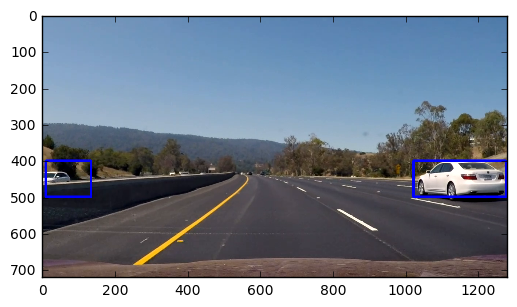

In [64]:
pipeline = Pipeline(xy_windows = [(100,100)],xy_overlap=(0.95, 0.95),heat_threshold=1)
clip0 = VideoFileClip('project_video.mp4')
image = clip0.get_frame(10*25/25)
result = pipeline.process_frame(image)
plt.imshow(result)

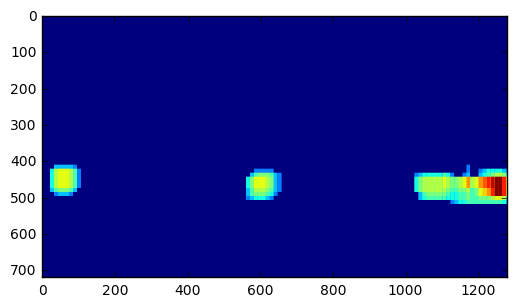

In [17]:
plt.imshow(pipeline.heatmap)

4 cars found


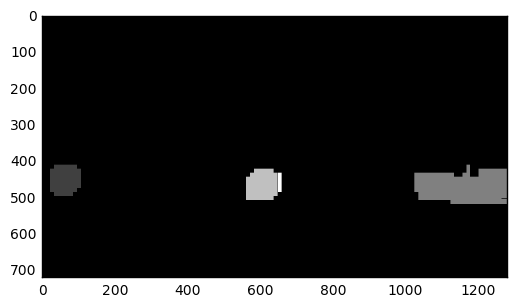

In [18]:
from scipy.ndimage.measurements import label
labels = label(pipeline.heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')